# Analiza różnic w rankigach

Analiza różnic pomiędzy:
- dokładną metodą - exact_ranking
- metodą przybliżania dla 1000 iteracji

In [85]:
import os
while "notebooks" in os.getcwd():
    os.chdir("../")


In [86]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Wczytywanie rankingów i zbioru danych

In [87]:
result_path = Path("results")
exact_ranking_data_path = result_path / "wine_exact_ranking_std_0.3.npy"
approx_ranking_data_path = result_path / "wine_approx_ranking_4000_iter.npy"
shap_ranking_data = result_path / "wine_shap_ranking.npy"
data_path = Path("data")
wine_test_data_path = data_path / "wine_quality/test_winequality_red_scaled.csv"

In [153]:
pgi_wine_exact_path = result_path / "pgi_wine_exact_ranking_std_0.3_pgi_std_0.3.npy"
pgi_wine_shap_path = result_path / "pgi_wine_shap_ranking.npy"
pgi_wine_approx_path = result_path / "pgi_wine_approx_ranking_4000_iter_pgi_std_0.3.npy"

In [155]:
top_k_pgi_path = Path("results/top_k_pgi")

In [156]:
wine_data = pd.read_csv(wine_test_data_path)
wine_data

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,-0.241094,-1.887226,0.765247,-0.666062,-0.647527,0.203223,-0.500769,-1.455778,-0.136798,0.187963,0.729364,6
1,-1.045437,-1.049255,-0.005010,0.185312,-0.434990,-0.753085,-0.075043,-1.540580,-0.655141,-0.579207,1.480302,6
2,0.103624,-1.160984,0.765247,-0.169427,-0.264960,-0.370562,-0.835267,-1.275573,-1.108690,0.305990,1.292568,7
3,-0.700719,-0.546472,0.765247,2.100902,-0.349975,1.159531,2.479310,0.293268,0.705508,0.305990,0.072294,5
4,2.229387,-0.434742,1.124700,-0.807957,-0.264960,-1.231239,-1.230584,0.081262,-1.173483,-0.166115,-0.021574,5
...,...,...,...,...,...,...,...,...,...,...,...,...
315,-0.470907,0.291499,1.484154,0.398155,1.392830,-1.039977,-0.987312,-1.052967,-0.655141,2.194408,1.104833,6
316,-0.068735,-0.993390,0.303093,-0.098479,-0.243707,-0.466193,0.016184,-0.401050,-0.266384,0.896120,0.541630,6
317,0.390889,-0.323013,0.200392,0.114364,-0.073677,0.777007,2.388083,0.876283,-0.007213,-0.284141,-0.960246,5
318,0.046171,1.045674,-0.364463,-0.098479,-0.243707,-0.561823,-0.257497,0.319768,-0.007213,-0.107102,-0.960246,5


In [157]:
exact_ranking = np.load(exact_ranking_data_path)
exact_ranking.shape

(320, 11)

In [158]:
approx_ranking_4000 = np.load(approx_ranking_data_path)

In [159]:
shap_ranking = np.load(shap_ranking_data)
shap_ranking.shape

(320, 11)

# Analiza różnic w rankingach exact vs approx

In [160]:
features_map = {}
for indx, name in enumerate(list(wine_data.columns.values)):
    features_map[name] = indx

In [161]:
def map_features(li: list):
    mapped_li = [features_map[i] for i in li]
    return mapped_li

In [162]:

def distance_between_lists(a: list, b: list):
    a = map_features(a)
    b = map_features(b)
    a_s = set(a)
    b_s = set(b)
    [a.append(i) for i in list(b_s-a_s)]
    [b.append(i) for i in list(a_s-b_s)]
    max_val = max(max(a), max(b))
    all_numbers_set = set(range(max_val))
    a_s = set(a)
    b_s = set(b)
    [a.append(i) for i in list(all_numbers_set - a_s)]
    [b.append(i) for i in list(all_numbers_set - b_s)]
    return cayley_distance(a, b)

def cayley_distance(x: list, y: list):
    A = range(len(x))
    inv_y = tuple(y.index(a) for a in A)
    comp = tuple(x[inv_y[a]] for a in A)
    cycles = 0
    rem = set(A)
    while rem:
        a = rem.pop()
        cycles += 1
        while comp[a] in rem:
            a = comp[a]
            rem.remove(a)
    return len(A) - cycles


## Caylel distance

### All features

Porównanie obu rankingów za pomocą dystansu cayleya używając wszystkich cech

In [163]:
differences_all = []
for i, j in zip(exact_ranking, approx_ranking_4000):
    diff = distance_between_lists(i, j)
    differences_all.append(diff)

In [164]:
np.mean(differences_all)

4.55625

In [165]:
np.max(differences_all)

10

In [166]:
np.min(differences_all)

0

<Axes: >

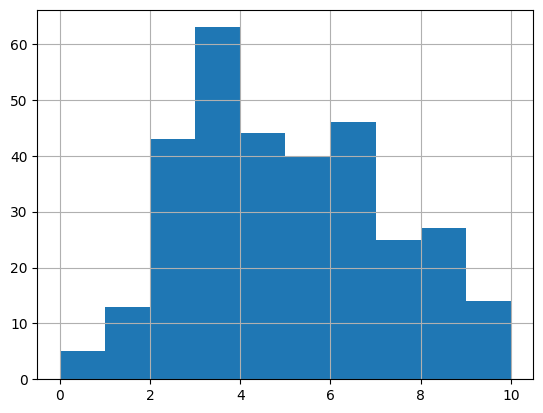

In [167]:
diff_ser = pd.Series(differences_all)
diff_ser.hist(bins=10)

In [168]:
indexes = [i for i, x in enumerate(differences_all) if x == 10]
indexes


[151]

In [169]:
print(exact_ranking[indexes[0]])
print(approx_ranking_4000[indexes[0]])

['residual_sugar' 'chlorides' 'pH' 'total_sulfur_dioxide'
 'free_sulfur_dioxide' 'fixed_acidity' 'volatile_acidity' 'citric_acid'
 'alcohol' 'sulphates' 'density']
['alcohol' 'residual_sugar' 'volatile_acidity' 'sulphates' 'citric_acid'
 'free_sulfur_dioxide' 'total_sulfur_dioxide' 'density' 'pH'
 'fixed_acidity' 'chlorides']


### Top 5 features

In [170]:
differences_5 = []
for i, j in zip(exact_ranking, approx_ranking_4000):
    i = i[0:5]
    j = j[0:5]
    diff = distance_between_lists(i, j)
    differences_5.append(diff)

In [171]:
np.mean(differences_5)

2.03125

In [172]:
np.max(differences_5)

8

In [173]:
np.min(differences_5)

0

<Axes: >

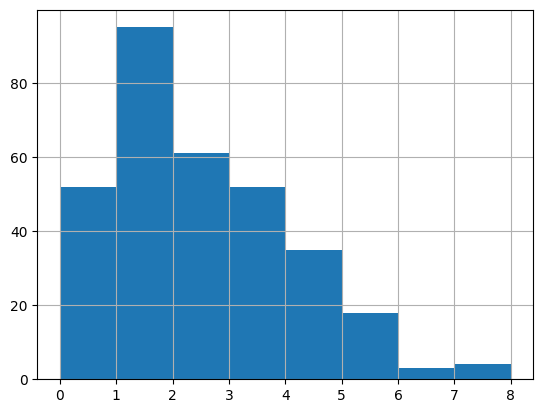

In [174]:
diff_ser = pd.Series(differences_5)
diff_ser.hist(bins=8)

In [175]:
indexes = [i for i, x in enumerate(differences_5) if x == 8]
indexes


[319]

In [176]:
print(exact_ranking[indexes[0]])
print(approx_ranking_4000[indexes[0]])

['pH' 'residual_sugar' 'sulphates' 'alcohol' 'density' 'volatile_acidity'
 'fixed_acidity' 'citric_acid' 'chlorides' 'total_sulfur_dioxide'
 'free_sulfur_dioxide']
['chlorides' 'volatile_acidity' 'total_sulfur_dioxide' 'sulphates'
 'free_sulfur_dioxide' 'fixed_acidity' 'density' 'citric_acid'
 'residual_sugar' 'pH' 'alcohol']


### Top 3 features

In [177]:
differences_3 = []
for i, j in zip(exact_ranking, approx_ranking_4000):
    i = i[0:3]
    j = j[0:3]
    diff = distance_between_lists(i, j)
    differences_3.append(diff)

In [178]:
np.mean(differences_3)

0.90625

In [179]:
np.max(differences_3)

5

In [180]:
np.min(differences_3)

0

<Axes: >

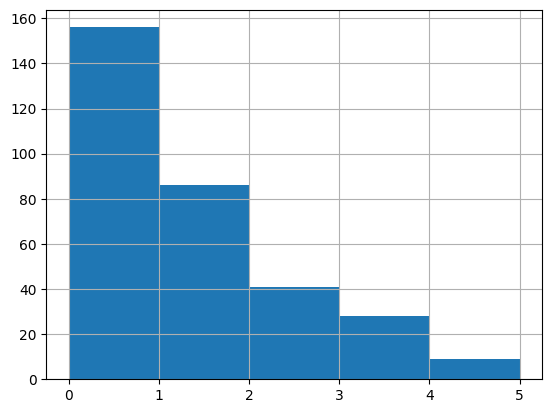

In [181]:
diff_ser = pd.Series(differences_3)
diff_ser.hist(bins=5)

In [182]:
indexes = [i for i, x in enumerate(differences_3) if x == 3]
indexes


[33,
 40,
 46,
 67,
 69,
 101,
 105,
 106,
 108,
 111,
 127,
 143,
 151,
 174,
 178,
 183,
 184,
 200,
 217,
 218,
 228,
 240,
 246,
 252,
 264,
 271,
 284,
 288]

In [183]:
print(exact_ranking[indexes[0]])
print(approx_ranking_4000[indexes[0]])

['pH' 'chlorides' 'total_sulfur_dioxide' 'volatile_acidity'
 'residual_sugar' 'citric_acid' 'density' 'fixed_acidity'
 'free_sulfur_dioxide' 'sulphates' 'alcohol']
['sulphates' 'pH' 'alcohol' 'volatile_acidity' 'total_sulfur_dioxide'
 'chlorides' 'residual_sugar' 'citric_acid' 'density' 'fixed_acidity'
 'free_sulfur_dioxide']


## Diffrence between sets

Porównaie używając tylko różicy w zbiorach top k cech - bez brania pod uwagę kolejności

In [184]:
def set_difference(a: list, b: list):
    a_s = set(a)
    b_s = set(b)
    diff = a_s.difference(b_s) 
    return len(diff)

### Top 5 features

In [185]:
set_differences_5 = []
for i, j in zip(exact_ranking, approx_ranking_4000):
    i = i[0:5]
    j = j[0:5]
    diff = set_difference(i, j)
    set_differences_5.append(diff)

In [186]:
np.mean(set_differences_5)

0.853125

In [187]:
np.max(set_differences_5)

4

In [188]:
np.min(set_differences_5)

0

<Axes: >

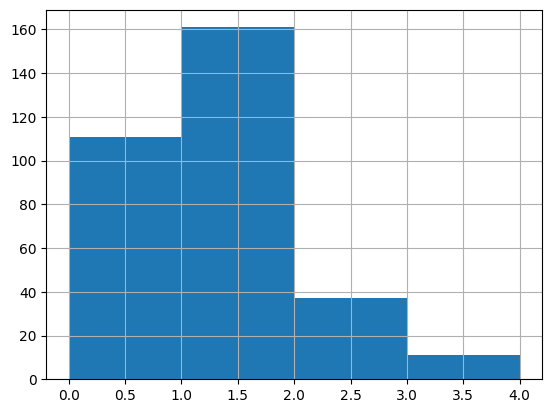

In [189]:
diff_ser = pd.Series(set_differences_5)
diff_ser.hist(bins=4)

In [190]:
indexes = [i for i, x in enumerate(set_differences_5) if x == 4]
indexes


[151, 183, 233, 295, 319]

In [191]:
print(exact_ranking[indexes[0]])
print(approx_ranking_4000[indexes[0]])

['residual_sugar' 'chlorides' 'pH' 'total_sulfur_dioxide'
 'free_sulfur_dioxide' 'fixed_acidity' 'volatile_acidity' 'citric_acid'
 'alcohol' 'sulphates' 'density']
['alcohol' 'residual_sugar' 'volatile_acidity' 'sulphates' 'citric_acid'
 'free_sulfur_dioxide' 'total_sulfur_dioxide' 'density' 'pH'
 'fixed_acidity' 'chlorides']


### Top 3 features

In [192]:
set_differences_3 = []
for i, j in zip(exact_ranking, approx_ranking_4000):
    i = i[0:3]
    j = j[0:3]
    diff = set_difference(i, j)
    set_differences_3.append(diff)

In [193]:
np.mean(set_differences_3)

0.5125

In [194]:
np.max(set_differences_3)

3

In [195]:
np.min(set_differences_3)

0

<Axes: >

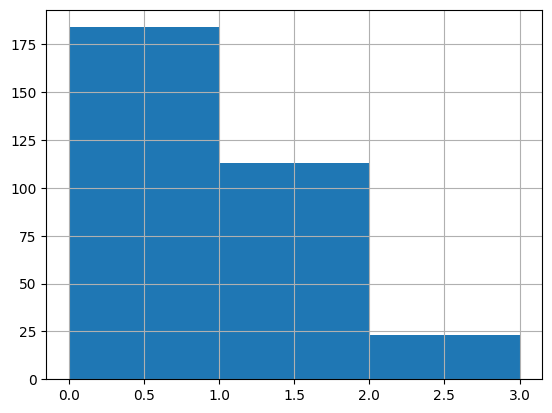

In [196]:
diff_ser = pd.Series(set_differences_3)
diff_ser.hist(bins=3)

In [197]:
indexes = [i for i, x in enumerate(set_differences_3) if x == 3]
indexes


[178, 183, 233, 293, 319]

In [198]:
print(exact_ranking[indexes[0]])
print(approx_ranking_4000[indexes[0]])

['residual_sugar' 'pH' 'density' 'chlorides' 'free_sulfur_dioxide'
 'total_sulfur_dioxide' 'fixed_acidity' 'sulphates' 'alcohol'
 'volatile_acidity' 'citric_acid']
['alcohol' 'volatile_acidity' 'sulphates' 'residual_sugar' 'density' 'pH'
 'chlorides' 'total_sulfur_dioxide' 'free_sulfur_dioxide' 'fixed_acidity'
 'citric_acid']


# Porównanie z rankingiem z SHAP

In [199]:
approx_diffs = []
exact_diffs = []
for i, j, s in zip(exact_ranking, approx_ranking_4000, shap_ranking):
    diff_exact = distance_between_lists(i, s)
    diff_approx = distance_between_lists(j, s)
    exact_diffs.append(diff_exact)
    approx_diffs.append(diff_approx)

In [200]:
print(f"Exact {np.mean(exact_diffs)}  Approx {np.mean(approx_diffs)}")

Exact 7.659375  Approx 7.840625


In [201]:
print(f"Exact {np.max(exact_diffs)}  Approx {np.max(approx_diffs)}")

Exact 10  Approx 10


In [202]:
print(f"Exact {np.min(exact_diffs)}  Approx {np.min(approx_diffs)}")

Exact 4  Approx 3


<Axes: >

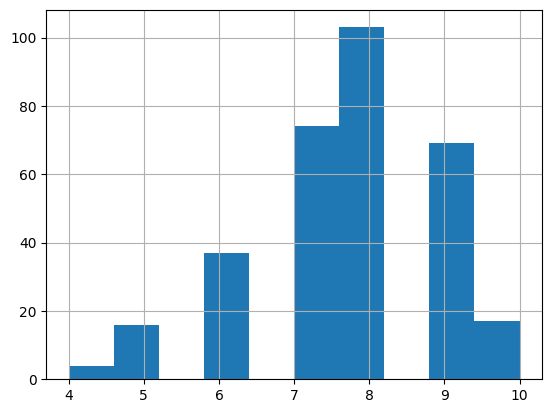

In [203]:
exact_diffs_ser = pd.Series(exact_diffs)
approx_diffs_ser = pd.Series(approx_diffs)
exact_diffs_ser.hist(bins=10)


<Axes: >

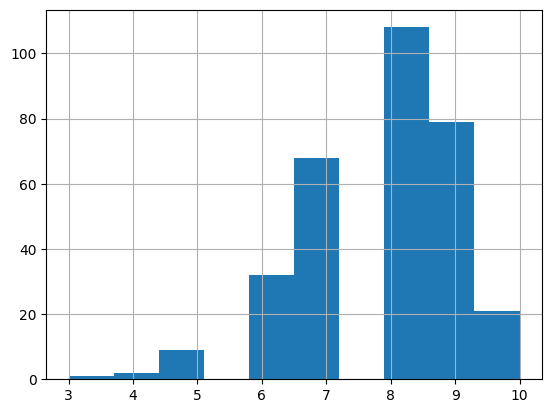

In [204]:
approx_diffs_ser.hist(bins=10)

# Ile pierwszych miejsc się zgadza

### Porównanie exact z approx

In [205]:
def compare(a: list[str], b: list[str]):
    assert (len (a) == len(b))
    for i, j in zip(a, b):
        if i == j:
            continue
        else:
            return False
    return True

<Axes: >

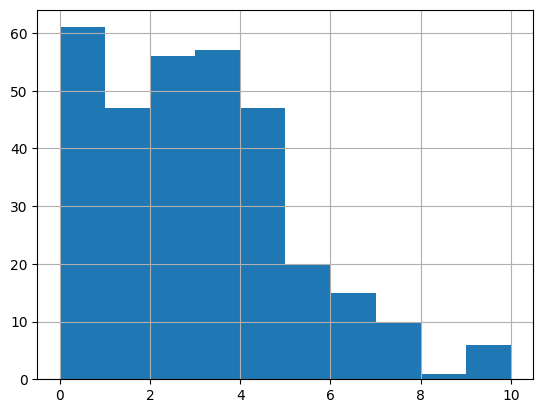

In [206]:
matching_count = [0 for i in range(0, 12)]
distances = []
for i, j in zip(exact_ranking, approx_ranking_4000):
    rank = 0
    for indx in range(1, len(i)):
        if compare(i[0: indx], j[0:indx]):
            rank += 1
    matching_count[rank] += 1
    distances.append(rank)

exact_diffs_ser = pd.Series(distances)
exact_diffs_ser.hist()





In [207]:
matching_count

[61, 47, 56, 57, 47, 20, 15, 10, 1, 1, 5, 0]

### Exact z shap

<Axes: >

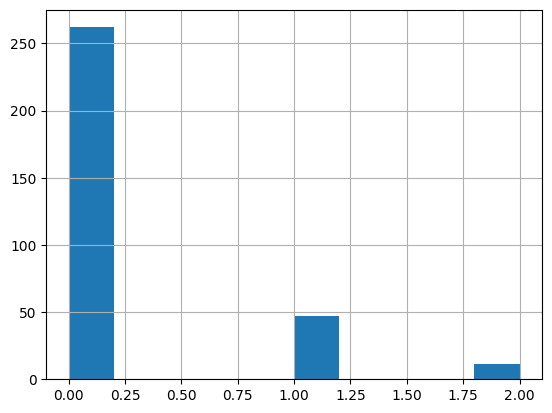

In [208]:

matching_count = [0 for i in range(0, 12)]
distances = []
for i, j in zip(exact_ranking, shap_ranking):
    rank = 0
    for indx in range(1, len(i)):
        if compare(i[0: indx], j[0:indx]):
            rank += 1
    matching_count[rank] += 1
    distances.append(rank)

exact_diffs_ser = pd.Series(distances)
exact_diffs_ser.hist(bins=10)





In [209]:
matching_count

[262, 47, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0]

### Approx z shap

<Axes: >

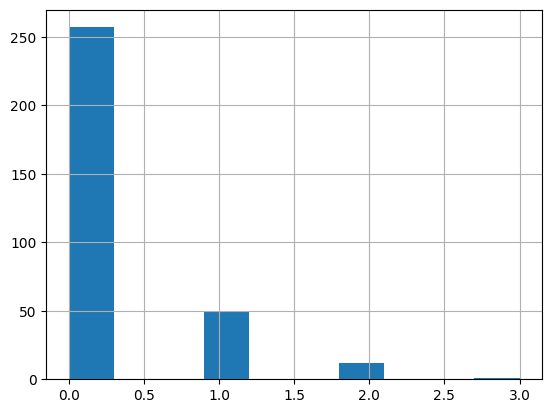

In [210]:
matching_count = [0 for i in range(0, 12)]
distances = []
for i, j in zip(approx_ranking_4000, shap_ranking):
    rank = 0
    for indx in range(1, len(i)):
        if compare(i[0: indx], j[0:indx]):
            rank += 1
    matching_count[rank] += 1
    distances.append(rank)

exact_diffs_ser = pd.Series(distances)
exact_diffs_ser.hist()





In [211]:
matching_count

[257, 50, 12, 1, 0, 0, 0, 0, 0, 0, 0, 0]

### Porównainie wszystkich trzech jednocześnie

In [212]:
def compare(a: list[str], b: list[str], c: list[str]):
    assert (len (a) == len(b))
    assert(len(a) == len(c))
    for i, j, y in zip(a, b, c):
        if i == j and i == y:
            continue
        else:
            return False
    return True

<Axes: >

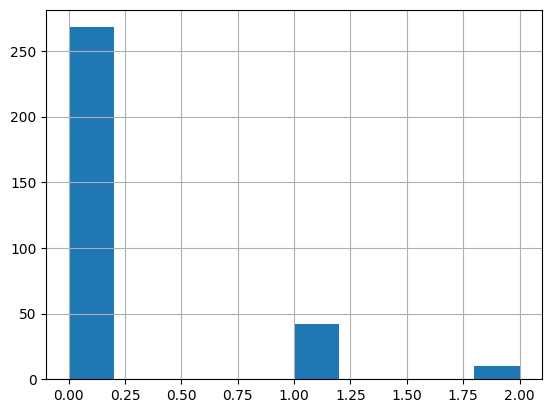

In [213]:
matching_count = [0 for i in range(0, 12)]
distances = []
for i, j, y in zip(approx_ranking_4000, shap_ranking, exact_ranking):
    rank = 0
    for indx in range(1, len(i)):
        if compare(i[0: indx], j[0:indx], y[0:indx]):
            rank += 1
    matching_count[rank] += 1
    distances.append(rank)

exact_diffs_ser = pd.Series(distances)
exact_diffs_ser.hist()





In [214]:
matching_count

[268, 42, 10, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# Porównanie dla PGI

In [215]:
pgi_wine_exact_ranking = np.load(pgi_wine_exact_path)
pgi_wine_shap_ranking = np.load(pgi_wine_shap_path)
pgi_wine_approx_ranking = np.load(pgi_wine_approx_path)



FileNotFoundError: [Errno 2] No such file or directory: 'results/pgi_wine_approx_ranking_4000_iter_pgi_std_0.3.npy'

In [ ]:
print(f"exact mean: {np.mean(pgi_wine_exact_ranking)}")
print(f"approx mean: {np.mean(pgi_wine_approx_ranking)}")
print(f"shap mean: {np.mean(pgi_wine_shap_ranking)}")

exact mean: 0.30338761009075615
approx mean: 0.3034437559209082
shap mean: 0.3097186281591527


<Axes: >

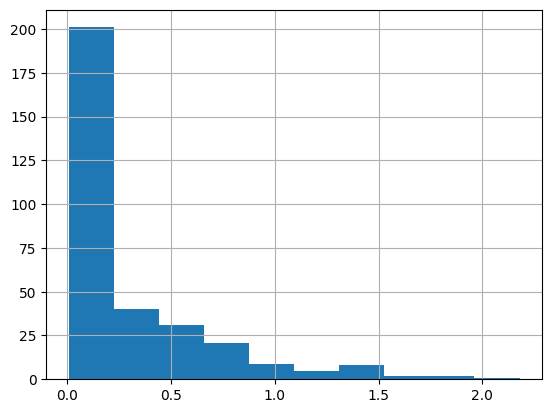

In [216]:
pgi_wine_exact_ranking = np.load(pgi_wine_exact_path)
exact_diffs_ser = pd.Series(pgi_wine_exact_ranking)
exact_diffs_ser.hist()

In [217]:
pgi_wine_exact_ranking.shape

(320,)

# Grid search

In [218]:
stddevs = [0.01, 0.03, 0.1, 0.3]


## Testing pgi for different top k features and different stds

In [222]:
def get_names(s, k):
    names = []
    names.append(f'pgi_wine_exact_ranking_std_{s}_pgi_std_{s}_topk_{k}.npy')
    names.append(f'pgi_wine_approx_ranking_4000_pgi_std_{s}_topk_{k}.npy')
    names.append(f'pgi_wine_shap_ranking_pgi_std_{s}_topk_{k}.npy')
    return names

In [223]:
methods = ['exact', 'approx', 'shap']
means = [[] for i in methods]
stds = [[]for i in methods]
for s in stddevs:
    means_tmp = [[] for i in methods]
    stds_tmp = [[] for i in methods]
    for k in range(1, 12):
        names = get_names(s, k) 
        for pgi_file_name, i in zip(names, range(0, len(methods))):
            pgi = np.load(top_k_pgi_path / pgi_file_name) 
            mean = np.mean(pgi)
            std = np.std(pgi)
            means_tmp[i].append(mean)
            stds_tmp[i].append(std)
    for i in range(0, len(methods)):
        means[i].append(means_tmp[i])
        stds[i].append(stds_tmp[i])

In [224]:
print(means[0][0][0])

0.005923199427969166


In [225]:
print(means[2][0][0])


0.004186407237196989


In [226]:
def draw_for_stdt(std_indx):
    for y, l in zip(means, methods):
        plt.errorbar(range(1, 12), y[std_indx], label = l)#, yerr = e)
        print(y[std_indx])

    plt.xlabel("k")
    plt.ylabel("PGI")
    plt.legend(loc = 'upper right')
    plt.title(f'PGI vs topk for std = {stddevs[std_indx]}')
    #plt.ylim(0.3, 0.32)
    plt.show()

[0.005923199427969166, 0.0060681804107731, 0.006129355172583653, 0.0061600323990737196, 0.006178439583691959, 0.006190711040105361, 0.006199476366057265, 0.00620535600258561, 0.006191705588915071, 0.006098458036038441, 0.005850751902998777]
[0.003762350237904358, 0.003661784841939622, 0.0036447929672307174, 0.003626273093255976, 0.0036088200643495183, 0.0035803245528981684, 0.0035570744310166927, 0.003537066288586128, 0.003521900275825579, 0.0035068550159087198, 0.003494749157426304]
[0.004186407237196989, 0.004043177050831709, 0.003989494949621326, 0.003961106038428937, 0.003945608758007185, 0.003919828750679138, 0.003889122841962199, 0.003852824982705785, 0.003818627076246389, 0.0037845090753273933, 0.0037471619387160074]


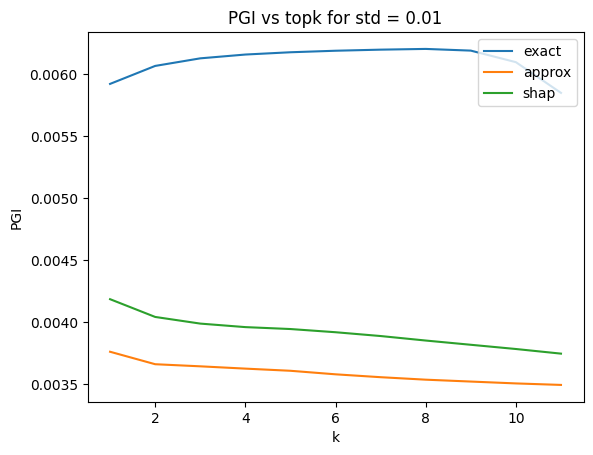

In [227]:
draw_for_stdt(0)

[0.006405501508980019, 0.006693233876116654, 0.006841077154380764, 0.006923094212773706, 0.006973775246343411, 0.007007871993954876, 0.007031911455502621, 0.0070467684428942665, 0.007026908333945864, 0.0069279158662367, 0.0066880319634415875]
[0.0041552582385491026, 0.004186959109699474, 0.0042665686213472585, 0.004304099700859504, 0.004322922612945738, 0.004318080372004146, 0.00431477041363144, 0.0043099154918831845, 0.00430876791382812, 0.004306675721970234, 0.004305086377744799]
[0.0042568816505858505, 0.004179880947342743, 0.004174371155234821, 0.004173280797697499, 0.004184147948208351, 0.004187090422768757, 0.00418707744180175, 0.004181163380589643, 0.004184516026476051, 0.004189442388646537, 0.004198510620177802]


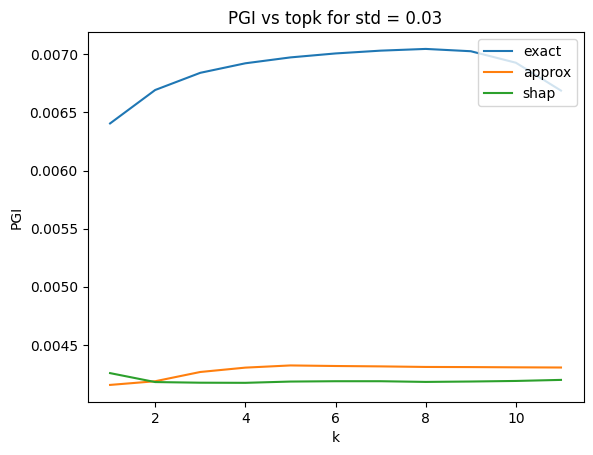

In [228]:
draw_for_stdt(1)

[0.010610917625615028, 0.012077934249705227, 0.013046684315383583, 0.0136875251683522, 0.014124487954751266, 0.01443130589392668, 0.014649513965175406, 0.014791181318018844, 0.014855026712401164, 0.014803703369634418, 0.01459914219906816]
[0.008068699630614106, 0.009208785403000163, 0.010013275248256733, 0.010542249620577374, 0.010916965398688864, 0.011182942093965158, 0.011391771002500094, 0.011547408877441332, 0.011673812926200275, 0.01177901233278506, 0.011849423074659653]
[0.00541804728339216, 0.005782607899305149, 0.006114896994377785, 0.006385283197113761, 0.006688651494897941, 0.006972302452369329, 0.007243544176792122, 0.007506553663437526, 0.0077991214066682624, 0.008142017592019251, 0.00854306421941801]


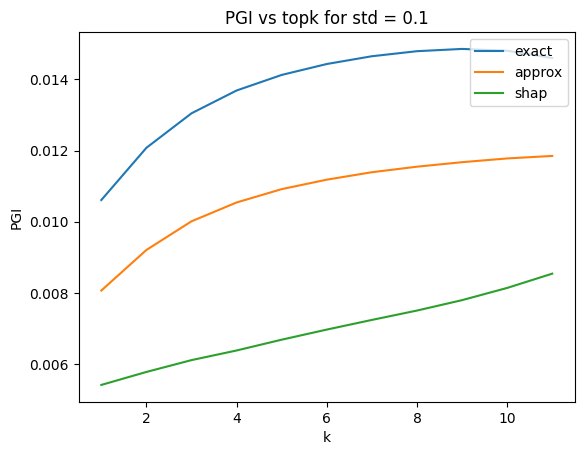

In [229]:
draw_for_stdt(2)

[0.025672336414747872, 0.03200041423280161, 0.03675492597102449, 0.040326570472821247, 0.04301947971482408, 0.045073051252415994, 0.04662715856275194, 0.04776770179584418, 0.04855320136469275, 0.04898795547997144, 0.04900231736966824]
[0.023564814046867673, 0.0294949461056798, 0.03397960007892916, 0.037318682207282475, 0.03985192279326598, 0.04179312501935149, 0.04331477745855257, 0.0444841955365762, 0.045353433374863215, 0.04597622624313635, 0.046264381699818155]
[0.011486283933121658, 0.014002117769306304, 0.015874016591297425, 0.017371688554719728, 0.01880757808686578, 0.020160558817215863, 0.021527791904215186, 0.02288530050849743, 0.024348293960357925, 0.02614543669621284, 0.02823639120261496]


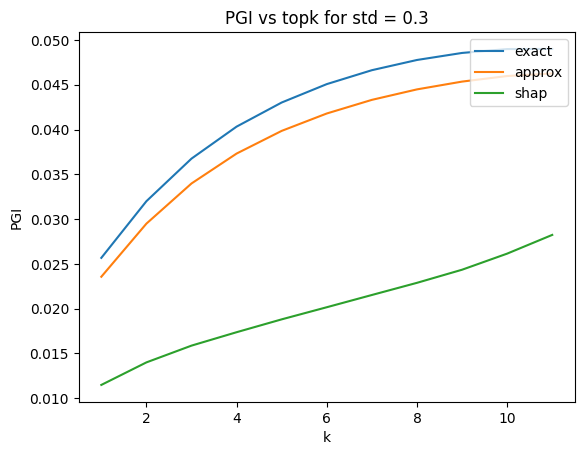

In [230]:
draw_for_stdt(3)

# Approx vs exact comparision

## 10 000 iterstions

In [231]:
comparision_path = Path("results/precision")

In [232]:
iterations = [10, 50, 100, 500, 1000, 2000, 4000, 8000, 10000]

In [233]:
def plot_for_std(std: float):
    means = []
    stds = []
    for i in iterations:
        arr = np.load(comparision_path / f'precision_comparision_std_{std}_iterations_{i}.npy')
        arr = arr[arr[:, 2] != 0]
        print(arr.shape)
        diffs =  np.abs(arr[:, 0] - arr[:, 1])*arr[:, 2]
        means.append(np.mean(diffs))
        stds.append(np.std(diffs))

    print(means)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(iterations, means)
    ax1.set(xlabel='Iterations"', ylabel='PGI Diff')
    ax1.legend(loc = 'upper right')
    title = f'Mean difference for \n PGI between methods for \n std = {std}'
    ax1.set(title = title)
    
    ax2.plot(iterations, stds)
    ax2.set(xlabel='Iterations"', ylabel='PGI Diff Std')
    ax2.legend(loc = 'upper right')
    title = f'Std of difference for \n PGI between methods for \n std = {std}'
    ax2.set(title = title)


    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
[0.01163751669602583, 0.009970631362805845, 0.009473446221962932, 0.00891964289322336, 0.008787143525295627, 0.008693989248093966, 0.00862413135377923, 0.008537405369719598, 0.008526065643836494]


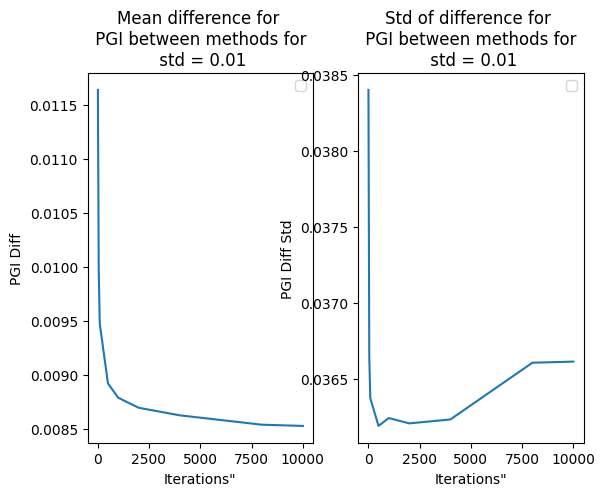

In [234]:
plot_for_std(0.01)

In [235]:

iterations = [10, 50, 100, 500, 1000, 2000, 4000, 8000, 10000]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
[0.01163751669602583, 0.009970631362805845, 0.009473446221962932, 0.00891964289322336, 0.008787143525295627, 0.008693989248093966, 0.00862413135377923, 0.008537405369719598, 0.008526065643836494]


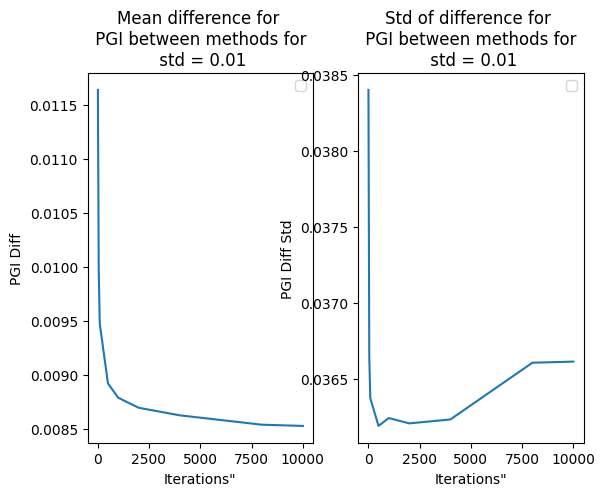

In [239]:
plot_for_std(0.01)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
[0.012799808383673018, 0.010062762311880578, 0.009461162590874029, 0.008596839141410555, 0.008369451162610909, 0.008252148041990816, 0.008149000066094427, 0.008086675987747916, 0.008053734448357438]


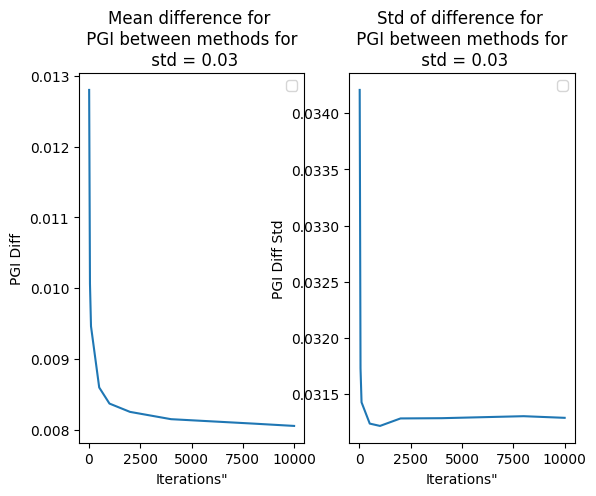

In [236]:
plot_for_std(0.03)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
[0.025549534610084572, 0.015954804734866188, 0.01366726747657668, 0.010934161714237691, 0.01038240221719079, 0.009873971172814555, 0.00956908364143419, 0.009302658151559442, 0.009258652310653006]


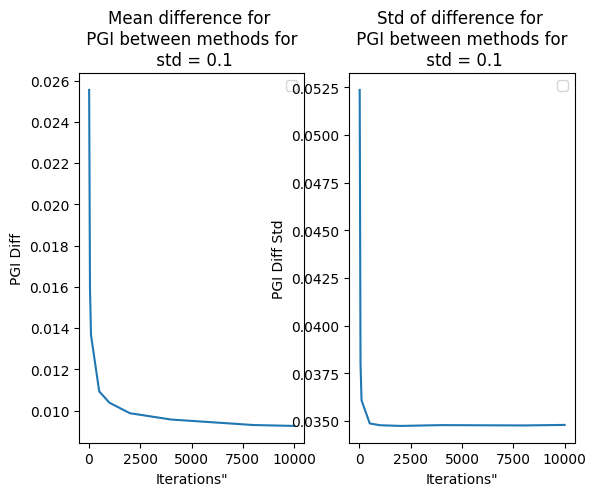

In [237]:
plot_for_std(0.1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
[0.08201258517727722, 0.0422128949499933, 0.03427673453814586, 0.021945534761133534, 0.019184661895818175, 0.017418000222932287, 0.016089593007361656, 0.0151835155769133, 0.014903330503676728]


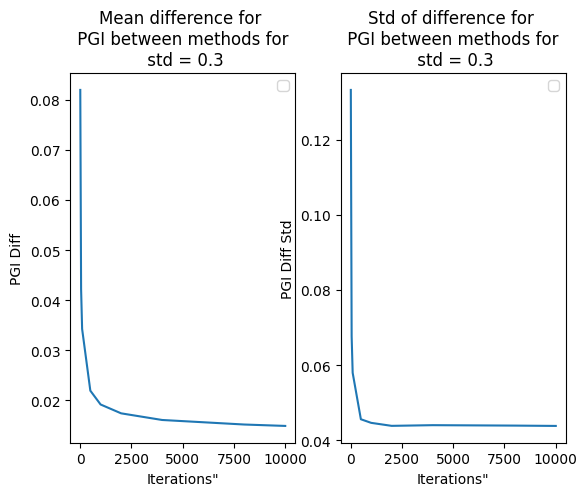

In [238]:
plot_for_std(0.3)